In [1]:
%matplotlib inline

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github

  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html
    
working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

Mounted at /content/drive
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/keyword_spotting
dataset/  main.py   models/     old_main.py   README.md        utilsFunc.py
.git/     metrics/  notebooks/  __pycache__/  SpeechCommands/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


imports done
parsing variables...
Using : cuda
Training mode
training loader set up, size 84843
validation loader set up, size 9981
training/validation sets finished in  0:00:18.203858
1  models have been set up
Launching  nameless_exp experience
expérience : 0


  0%|          | 0.004/2 [00:00<00:59, 29.95s/it]

train Epoch: 1 [0/84843 (0%)]	Loss: 3.810743


  1%|▏         | 0.028000000000000018/2 [00:00<00:55, 28.34s/it]

train Epoch: 1 [2000/84843 (2%)]	Loss: 3.434321


  2%|▏         | 0.04400000000000003/2 [00:01<00:59, 30.17s/it]

train Epoch: 1 [4000/84843 (5%)]	Loss: 3.353159


  3%|▎         | 0.06800000000000005/2 [00:01<00:55, 28.86s/it]

train Epoch: 1 [6000/84843 (7%)]	Loss: 3.181439


  4%|▍         | 0.08800000000000006/2 [00:02<00:54, 28.68s/it]

train Epoch: 1 [8000/84843 (9%)]	Loss: 3.174457


  5%|▌         | 0.10800000000000008/2 [00:03<00:54, 28.57s/it]

train Epoch: 1 [10000/84843 (12%)]	Loss: 2.983383


  6%|▋         | 0.12800000000000009/2 [00:03<00:53, 28.58s/it]

train Epoch: 1 [12000/84843 (14%)]	Loss: 3.028626


  7%|▋         | 0.1440000000000001/2 [00:04<00:52, 28.41s/it]

train Epoch: 1 [14000/84843 (16%)]	Loss: 2.670663


  8%|▊         | 0.16800000000000012/2 [00:04<00:52, 28.59s/it]

train Epoch: 1 [16000/84843 (19%)]	Loss: 2.686363


  9%|▉         | 0.18400000000000014/2 [00:05<00:52, 28.76s/it]

train Epoch: 1 [18000/84843 (21%)]	Loss: 2.606803


 10%|█         | 0.20800000000000016/2 [00:05<00:50, 28.20s/it]

train Epoch: 1 [20000/84843 (24%)]	Loss: 2.471275


 11%|█▏        | 0.22800000000000017/2 [00:06<00:50, 28.29s/it]

train Epoch: 1 [22000/84843 (26%)]	Loss: 2.590801


 12%|█▏        | 0.2480000000000002/2 [00:07<00:49, 28.51s/it]

train Epoch: 1 [24000/84843 (28%)]	Loss: 2.396031


 13%|█▎        | 0.2680000000000002/2 [00:07<00:49, 28.59s/it]

train Epoch: 1 [26000/84843 (31%)]	Loss: 2.365798


 14%|█▍        | 0.2880000000000002/2 [00:08<00:48, 28.34s/it]

train Epoch: 1 [28000/84843 (33%)]	Loss: 2.163167


 15%|█▌        | 0.3080000000000002/2 [00:08<00:48, 28.51s/it]

train Epoch: 1 [30000/84843 (35%)]	Loss: 2.334531


 16%|█▋        | 0.32800000000000024/2 [00:09<00:48, 28.90s/it]

train Epoch: 1 [32000/84843 (38%)]	Loss: 2.154313


 17%|█▋        | 0.34400000000000025/2 [00:09<00:47, 28.77s/it]

train Epoch: 1 [34000/84843 (40%)]	Loss: 2.127873


 18%|█▊        | 0.36800000000000027/2 [00:10<00:47, 28.91s/it]

train Epoch: 1 [36000/84843 (42%)]	Loss: 1.894694


 19%|█▉        | 0.3880000000000003/2 [00:11<00:46, 28.71s/it]

train Epoch: 1 [38000/84843 (45%)]	Loss: 2.066847


 20%|██        | 0.4080000000000003/2 [00:11<00:45, 28.67s/it]

train Epoch: 1 [40000/84843 (47%)]	Loss: 1.987322


 21%|██▏       | 0.4280000000000003/2 [00:12<00:45, 29.26s/it]

train Epoch: 1 [42000/84843 (49%)]	Loss: 1.751070


 22%|██▏       | 0.44800000000000034/2 [00:12<00:44, 28.85s/it]

train Epoch: 1 [44000/84843 (52%)]	Loss: 1.781944


 23%|██▎       | 0.46800000000000036/2 [00:13<00:44, 28.88s/it]

train Epoch: 1 [46000/84843 (54%)]	Loss: 1.929240


 24%|██▍       | 0.4840000000000004/2 [00:13<00:43, 28.84s/it] 

train Epoch: 1 [48000/84843 (57%)]	Loss: 1.901759


 25%|██▌       | 0.5040000000000003/2 [00:14<00:44, 29.86s/it]

train Epoch: 1 [50000/84843 (59%)]	Loss: 2.108025


 26%|██▌       | 0.5240000000000004/2 [00:15<00:43, 29.53s/it]

train Epoch: 1 [52000/84843 (61%)]	Loss: 1.740559


 27%|██▋       | 0.5480000000000004/2 [00:15<00:42, 29.05s/it]

train Epoch: 1 [54000/84843 (64%)]	Loss: 1.692693


 28%|██▊       | 0.5640000000000004/2 [00:16<00:41, 28.98s/it]

train Epoch: 1 [56000/84843 (66%)]	Loss: 1.410026


 29%|██▉       | 0.5880000000000004/2 [00:16<00:40, 29.00s/it]

train Epoch: 1 [58000/84843 (68%)]	Loss: 1.606136


 30%|███       | 0.6040000000000004/2 [00:17<00:41, 29.53s/it]

train Epoch: 1 [60000/84843 (71%)]	Loss: 1.652918


 31%|███▏      | 0.6280000000000004/2 [00:18<00:39, 28.85s/it]

train Epoch: 1 [62000/84843 (73%)]	Loss: 1.526568


 32%|███▏      | 0.6480000000000005/2 [00:18<00:39, 28.93s/it]

train Epoch: 1 [64000/84843 (75%)]	Loss: 1.463369


 33%|███▎      | 0.6640000000000005/2 [00:19<00:47, 35.89s/it]

train Epoch: 1 [66000/84843 (78%)]	Loss: 1.592975


 34%|███▍      | 0.6840000000000005/2 [00:19<00:49, 37.48s/it]

train Epoch: 1 [68000/84843 (80%)]	Loss: 1.417877


 35%|███▌      | 0.7040000000000005/2 [00:20<00:38, 29.98s/it]

train Epoch: 1 [70000/84843 (82%)]	Loss: 1.360799


 36%|███▋      | 0.7280000000000005/2 [00:21<00:38, 29.93s/it]

train Epoch: 1 [72000/84843 (85%)]	Loss: 1.482196


 37%|███▋      | 0.7480000000000006/2 [00:21<00:35, 28.65s/it]

train Epoch: 1 [74000/84843 (87%)]	Loss: 1.355672


 38%|███▊      | 0.7680000000000006/2 [00:22<00:34, 28.14s/it]

train Epoch: 1 [76000/84843 (90%)]	Loss: 1.526630


 39%|███▉      | 0.7840000000000006/2 [00:22<00:35, 29.11s/it]

train Epoch: 1 [78000/84843 (92%)]	Loss: 1.409198


 40%|████      | 0.8080000000000006/2 [00:23<00:34, 28.74s/it]

train Epoch: 1 [80000/84843 (94%)]	Loss: 1.394144


 41%|████▏     | 0.8280000000000006/2 [00:24<00:33, 28.68s/it]

train Epoch: 1 [82000/84843 (97%)]	Loss: 1.357672


 42%|████▏     | 0.8440000000000006/2 [00:24<00:33, 28.96s/it]

train Epoch: 1 [84000/84843 (99%)]	Loss: 1.223799


 43%|████▎     | 0.8570000000000007/2 [00:24<00:30, 26.78s/it]

val Epoch: 1 [0/9981 (0%)]	Loss: 1.326464


 44%|████▍     | 0.8760000000000007/2 [00:25<00:28, 25.23s/it]

val Epoch: 1 [2000/9981 (20%)]	Loss: 1.351399


 45%|████▍     | 0.8970000000000007/2 [00:25<00:28, 25.56s/it]

val Epoch: 1 [4000/9981 (40%)]	Loss: 1.398114


 46%|████▌     | 0.9180000000000007/2 [00:26<00:26, 24.88s/it]

val Epoch: 1 [6000/9981 (60%)]	Loss: 1.114193


 47%|████▋     | 0.9370000000000007/2 [00:26<00:26, 24.71s/it]

val Epoch: 1 [8000/9981 (80%)]	Loss: 1.132225


 48%|████▊     | 0.9520000000000007/2 [00:27<00:28, 27.00s/it]


validation Epoch: 1	Accuracy: 6422/9981 (64%)

saving model nameless_exp/M5.pt
train Epoch: 2 [0/84843 (0%)]	Loss: 1.193238


 49%|████▉     | 0.9760000000000008/2 [00:28<00:29, 28.41s/it]

train Epoch: 2 [2000/84843 (2%)]	Loss: 1.081163


 50%|████▉     | 0.9960000000000008/2 [00:28<00:28, 28.45s/it]

train Epoch: 2 [4000/84843 (5%)]	Loss: 1.109921


 51%|█████     | 1.015999999999999/2 [00:29<00:28, 28.66s/it] 

train Epoch: 2 [6000/84843 (7%)]	Loss: 1.241951


 52%|█████▏    | 1.0359999999999967/2 [00:29<00:27, 28.60s/it]

train Epoch: 2 [8000/84843 (9%)]	Loss: 1.179732


 53%|█████▎    | 1.0559999999999945/2 [00:30<00:27, 28.87s/it]

train Epoch: 2 [10000/84843 (12%)]	Loss: 1.333111


 54%|█████▍    | 1.0759999999999923/2 [00:30<00:26, 28.61s/it]

train Epoch: 2 [12000/84843 (14%)]	Loss: 1.309182


 55%|█████▍    | 1.09599999999999/2 [00:31<00:25, 28.35s/it]  

train Epoch: 2 [14000/84843 (16%)]	Loss: 0.983890


 56%|█████▌    | 1.115999999999988/2 [00:32<00:25, 29.28s/it] 

train Epoch: 2 [16000/84843 (19%)]	Loss: 1.390254


 57%|█████▋    | 1.1359999999999857/2 [00:32<00:24, 28.92s/it]

train Epoch: 2 [18000/84843 (21%)]	Loss: 0.955862


 58%|█████▊    | 1.1559999999999835/2 [00:33<00:24, 28.74s/it]

train Epoch: 2 [20000/84843 (24%)]	Loss: 0.949730


 59%|█████▉    | 1.1759999999999813/2 [00:33<00:24, 29.96s/it]

train Epoch: 2 [22000/84843 (26%)]	Loss: 1.049783


 60%|█████▉    | 1.195999999999979/2 [00:34<00:23, 28.85s/it] 

train Epoch: 2 [24000/84843 (28%)]	Loss: 1.174392


 61%|██████    | 1.2159999999999769/2 [00:35<00:22, 29.22s/it]

train Epoch: 2 [26000/84843 (31%)]	Loss: 1.105596


 62%|██████▏   | 1.2359999999999747/2 [00:35<00:21, 28.61s/it]

train Epoch: 2 [28000/84843 (33%)]	Loss: 0.964419


 63%|██████▎   | 1.2559999999999725/2 [00:36<00:21, 29.11s/it]

train Epoch: 2 [30000/84843 (35%)]	Loss: 0.921431


 64%|██████▍   | 1.2759999999999703/2 [00:36<00:20, 28.62s/it]

train Epoch: 2 [32000/84843 (38%)]	Loss: 1.034233


 65%|██████▍   | 1.295999999999968/2 [00:37<00:20, 29.07s/it] 

train Epoch: 2 [34000/84843 (40%)]	Loss: 1.218346


 66%|██████▌   | 1.3159999999999659/2 [00:37<00:19, 28.94s/it]

train Epoch: 2 [36000/84843 (42%)]	Loss: 0.941546


 67%|██████▋   | 1.3359999999999637/2 [00:38<00:19, 28.83s/it]

train Epoch: 2 [38000/84843 (45%)]	Loss: 0.930597


 68%|██████▊   | 1.3559999999999615/2 [00:39<00:18, 28.96s/it]

train Epoch: 2 [40000/84843 (47%)]	Loss: 0.969472


 69%|██████▉   | 1.3759999999999593/2 [00:39<00:17, 28.57s/it]

train Epoch: 2 [42000/84843 (49%)]	Loss: 1.038730


 70%|██████▉   | 1.395999999999957/2 [00:40<00:17, 29.11s/it] 

train Epoch: 2 [44000/84843 (52%)]	Loss: 1.059582


 71%|███████   | 1.4159999999999549/2 [00:40<00:16, 28.76s/it]

train Epoch: 2 [46000/84843 (54%)]	Loss: 0.996530


 72%|███████▏  | 1.4359999999999526/2 [00:41<00:16, 28.66s/it]

train Epoch: 2 [48000/84843 (57%)]	Loss: 1.094255


 73%|███████▎  | 1.4559999999999504/2 [00:41<00:16, 30.31s/it]

train Epoch: 2 [50000/84843 (59%)]	Loss: 1.179078


 74%|███████▍  | 1.4759999999999482/2 [00:42<00:15, 28.67s/it]

train Epoch: 2 [52000/84843 (61%)]	Loss: 1.090309


 75%|███████▍  | 1.495999999999946/2 [00:43<00:14, 28.81s/it] 

train Epoch: 2 [54000/84843 (64%)]	Loss: 1.165865


 76%|███████▌  | 1.5159999999999438/2 [00:43<00:13, 28.81s/it]

train Epoch: 2 [56000/84843 (66%)]	Loss: 1.138210


 77%|███████▋  | 1.5359999999999416/2 [00:44<00:13, 28.47s/it]

train Epoch: 2 [58000/84843 (68%)]	Loss: 0.728603


 78%|███████▊  | 1.5559999999999394/2 [00:44<00:12, 28.36s/it]

train Epoch: 2 [60000/84843 (71%)]	Loss: 0.949223


 79%|███████▉  | 1.5759999999999372/2 [00:45<00:12, 30.36s/it]

train Epoch: 2 [62000/84843 (73%)]	Loss: 1.062331


 80%|███████▉  | 1.595999999999935/2 [00:46<00:12, 31.54s/it] 

train Epoch: 2 [64000/84843 (75%)]	Loss: 0.780711


 81%|████████  | 1.6159999999999328/2 [00:46<00:11, 29.50s/it]

train Epoch: 2 [66000/84843 (78%)]	Loss: 1.073449


 82%|████████▏ | 1.6359999999999306/2 [00:47<00:10, 30.02s/it]

train Epoch: 2 [68000/84843 (80%)]	Loss: 1.219032


 83%|████████▎ | 1.6559999999999284/2 [00:47<00:10, 29.37s/it]

train Epoch: 2 [70000/84843 (82%)]	Loss: 1.151962


 84%|████████▍ | 1.6759999999999262/2 [00:48<00:09, 28.47s/it]

train Epoch: 2 [72000/84843 (85%)]	Loss: 0.896898


 85%|████████▍ | 1.695999999999924/2 [00:49<00:08, 28.17s/it] 

train Epoch: 2 [74000/84843 (87%)]	Loss: 0.862691


 86%|████████▌ | 1.7159999999999218/2 [00:49<00:08, 28.96s/it]

train Epoch: 2 [76000/84843 (90%)]	Loss: 1.126710


 87%|████████▋ | 1.7359999999999196/2 [00:50<00:07, 29.61s/it]

train Epoch: 2 [78000/84843 (92%)]	Loss: 0.951012


 88%|████████▊ | 1.7559999999999174/2 [00:50<00:06, 28.61s/it]

train Epoch: 2 [80000/84843 (94%)]	Loss: 0.986376


 89%|████████▉ | 1.7759999999999152/2 [00:51<00:06, 28.81s/it]

train Epoch: 2 [82000/84843 (97%)]	Loss: 0.882098


 90%|████████▉ | 1.795999999999913/2 [00:51<00:05, 28.69s/it] 

train Epoch: 2 [84000/84843 (99%)]	Loss: 1.054690


 90%|█████████ | 1.804999999999912/2 [00:52<00:05, 26.78s/it] 

val Epoch: 2 [0/9981 (0%)]	Loss: 0.943246


 91%|█████████ | 1.82299999999991/2 [00:52<00:04, 25.50s/it]  

val Epoch: 2 [2000/9981 (20%)]	Loss: 0.655116


 92%|█████████▏| 1.8429999999999078/2 [00:53<00:03, 24.58s/it]

val Epoch: 2 [4000/9981 (40%)]	Loss: 0.957573


 93%|█████████▎| 1.8659999999999053/2 [00:53<00:03, 24.84s/it]

val Epoch: 2 [6000/9981 (60%)]	Loss: 1.000827


 94%|█████████▍| 1.885999999999903/2 [00:54<00:02, 25.02s/it] 

val Epoch: 2 [8000/9981 (80%)]	Loss: 0.891533


 95%|█████████▍| 1.8979999999999018/2 [00:54<00:02, 28.69s/it]



validation Epoch: 2	Accuracy: 7430/9981 (74%)

saving model nameless_exp/M5.pt
saving plot : nameless_exp/M5.pt.png


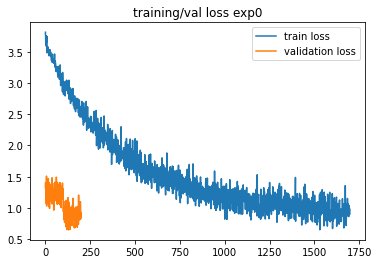

main program finished in  0:00:54.681535


In [6]:
%run main.py --model M5 --COLAB --save_checkpoint 'M5.pt'

In [ ]:
%run main.py --num-epochs 1

imports done
parsing variables...
Using : cpu
Training mode
training loader set up
validation loader set up
training/validation sets finished in  0:01:23.461948
1  models have been set up


  0%|          | 0.001053740779768177/1 [00:23<6:03:35, 21838.45s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 4.029365


  2%|▏         | 0.022128556375131718/1 [07:41<5:37:56, 20734.99s/it] 

Train Epoch: 1 [2000/84843 (2%)]	Loss: 3.547853


  4%|▍         | 0.04320337197049528/1 [14:53<5:25:28, 20410.42s/it] 

Train Epoch: 1 [4000/84843 (5%)]	Loss: 3.532417


  6%|▋         | 0.06427818756585883/1 [22:02<5:18:38, 20431.42s/it] 

Train Epoch: 1 [6000/84843 (7%)]	Loss: 3.525298


  9%|▊         | 0.0853530031612224/1 [29:18<5:09:31, 20304.86s/it] 

Train Epoch: 1 [8000/84843 (9%)]	Loss: 3.534493


 11%|█         | 0.10642781875658595/1 [36:25<5:00:53, 20204.16s/it]

Train Epoch: 1 [10000/84843 (12%)]	Loss: 3.472052


 11%|█         | 0.10958904109589049/1 [37:34<5:05:16, 20570.74s/it]


training program finished in  0:37:34.342032


KeyboardInterrupt: 

In [ ]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

PATH='spectr.pt'
storage['training_mode']=True

## Downloading and setting up the dataset

In [ ]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    if 'train_set' not in locals():  
        train_set = SubsetSC("training",root)
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = train_set[0]

# TODO : We are doing it without resampling it.
#resample_transform=torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate)

In [ ]:
print(len(train_set))
print(len(test_set))

## Let's visualize the data !

In [ ]:
plt.plot(storage['waveform'].t().numpy())

In [ ]:
from scipy import signal
from scipy.fft import fftshift

fe=16000
noverlap=int(20e-3*fe)
nperseg=int(30e-3*fe)
f, t, Sxx = signal.spectrogram(storage['waveform'][0], fe,noverlap=noverlap,nperseg=nperseg)
plt.pcolormesh(t, f, Sxx)
print(Sxx.shape)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:

n_mels=50
win_length=int(30e-3 *fe)
hop_length=int(10e-3 *fe)
n_fft=win_length 
spec_size=(fe -win_length)/hop_length +1
print('size of tensor should be ',spec_size)

### Spectrogram transform

In [ ]:
spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft,win_length=win_length,hop_length=hop_length)

spectrogram=spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram.size()))

plt.figure()
plt.imshow(spectrogram.log2()[0].numpy())

## Resampling the data and setting the transform

In [ ]:
layers =[]
layers.append(spectrogram_transform)

storage['transform'] = nn.Sequential(*layers)

waveform_size=storage['transform'](storage['waveform']).shape
print(waveform_size)

## Setting up the test and train loader

In [ ]:
batch_size = 100

if storage['device'] == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    
storage['train_loader']  = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
storage['test_loader']  = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=test_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the network

In [ ]:
storage['model'] = spectrogram_model(input_shape=waveform_size, n_output=len(train_set.labels))
if not storage['training_mode'] :
    storage['model'].load_state_dict(torch.load(PATH))
    storage['model'].eval()
storage['model'].to(storage['device'])
#print(storage['model'])
print("Number of parameters: %s" % storage['model'].count_parameters())

## Define the optimizer, loss function & metrics

In [ ]:
# Define the Optimizer
lr=0.001 
storage['optimizer'] = optim.Adam(storage['model'].parameters(), lr=lr, weight_decay=0.0001)
storage['scheduler'] = optim.lr_scheduler.StepLR(storage['optimizer'], step_size=20,
                                      gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
#Define the loss Function
storage['lossFunc']=F.cross_entropy
#Define the metrics :
storage['metrics']=metrics.countCorrectOutput

## Define the log interval and epochs

In [ ]:
storage['log_interval'] = 20
storage['n_epoch'] = 2

storage['pbar_update']  = 1 / (len(storage['train_loader']) + len(storage['test_loader']))
storage['losses'] = []
# The transform needs to live on the same device as the model and the data.

storage['transform'] = storage['transform'].to(storage['device'])

## Training

In [ ]:
if storage['training_mode'] :
    with timeThat('Main program') :
        with tqdm(total=storage['n_epoch']) as pbar:
            storage['pbar']=pbar
            for epoch in range(1, storage['n_epoch'] + 1):
                storage['epoch']=epoch
                train(storage)
                test(storage)
                storage['scheduler'].step()

In [ ]:
plt.plot(storage['losses']);
plt.title("training loss");

In [ ]:
FirstLayerWeights = storage['model'].conv1.weight.detach().cpu().numpy()

In [ ]:
plot_kernels2D(FirstLayerWeights)

In [ ]:
a=FirstLayerWeights[0,0].T
plt.imshow(a)
plt.show()

In [ ]:
torch.save(storage['model'].state_dict(), PATH)